<center><h1> Train models - Customer Segmentation</h1></center>

<img src='../references/banner.png'>

That is the third jupyter notebook of this project. To run this properly, you should have runned the previous jupyter notebooks.

In this file, we will load the preprocessed data, scale the data and train some machine learning models that will cluster our data into different number of segments. We will also use some metrics to measure each cluster and choose one that best suits the grocery business needs.

Let's get started and train the models.

<i>Import the libraries </i>

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import matplotlib.pyplot as plt
from pickle import dump

<i>Load the data</i>

In [6]:
## LOAD THE DATA
df_customers = pd.read_pickle('../data/processed/01_built_features.pkl')

In this project, we will use KMeans to cluster the data. This algorithm works best if the data is scaled, so let's scale the data:

In [7]:
## SCALE THE DATA
scaler = StandardScaler()
scaled_customers = scaler.fit_transform(df_customers)

scaled_customers = pd.DataFrame(scaled_customers, 
                                columns=df_customers.columns)

Now that our data is scaled, we will cluster the data into segments. We'll try to cluster into 2, 3, 4, 5, 7 and 7 clusters and see how each cluster performs against some metrics:

In [8]:
## CLUSTERING

cluster_nums = [2,3,4,5]
scores = []
sum_of_squared_distances = []

for cluster_num in cluster_nums:
    # kmeans
    kmeans = KMeans(n_clusters=cluster_num, random_state=0, n_init=10)
    # train model
    kmeans.fit(scaled_customers)
    # predict clusters for each point
    clusters = kmeans.predict(scaled_customers)
    # calculate silhouet score - it's a measure of clustering
    silhouette = silhouette_score(scaled_customers, clusters)
    scores.append(silhouette)

The first measure we will use is called Silhouette score. It measures the goodness of a clustering process and its value ranges from -1 to 1. Closer to 1 means good clustering, closer to 0 means indifferent, closer to -1 means cluster are assigned in the wrong way.

Let's see the silhouette score for each clustering:

Text(0.5, 1.0, 'Silhouette Score by n clusters')

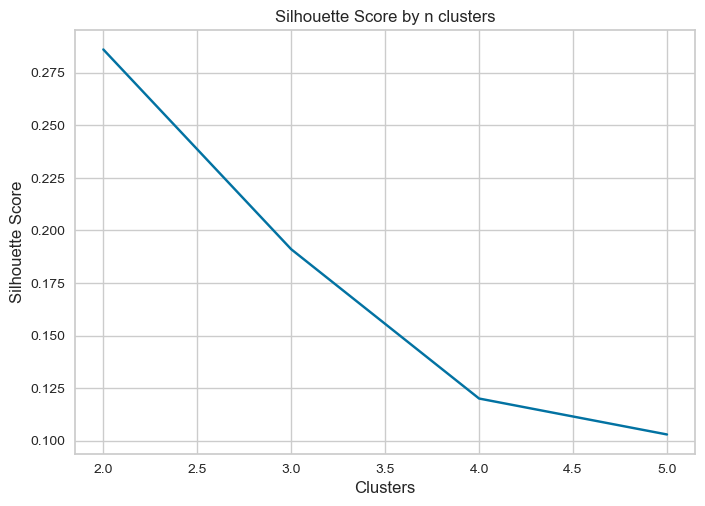

In [9]:
## PLOT RESULTS

# Silhouette score
sns.set_style('whitegrid')
plt.ylabel('Silhouette Score')
plt.xlabel('Clusters')
sns.lineplot(x=cluster_nums,y=scores)
plt.title('Silhouette Score by n clusters')

Two clusters have the highest silhouette score clustering. But it's not a rule that we should always choose the highest silhouette score. Let's visualize the data points against the silhouette score for each cluster, denoted by the red line.

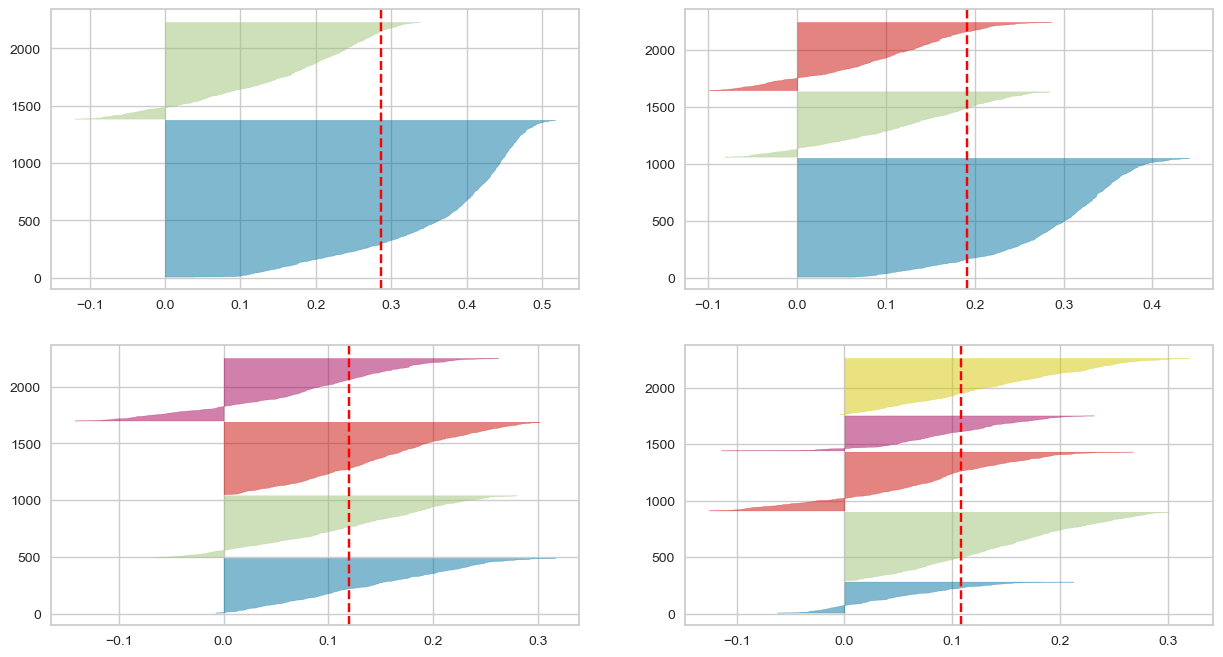

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(scaled_customers)

So, in order to choose the best k cluster, we will use the following criterias:
* For each K, choose the one ones which have a score higher than the mean;
* Each cluster have similar sizes;

Cluster 3 seems to have the best scores and sizes, considering both criterias. Anyway, we will see how the algorithm cluster 2 and 3 segments of customers to make a decision.

In [11]:
# Train 2 groups kmeans
kmeans_2groups = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_2groups.fit(scaled_customers)

# Train 3 groups kmeans
kmeans_3groups = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans_3groups.fit(scaled_customers)

KMeans(n_clusters=3, n_init=10, random_state=0)

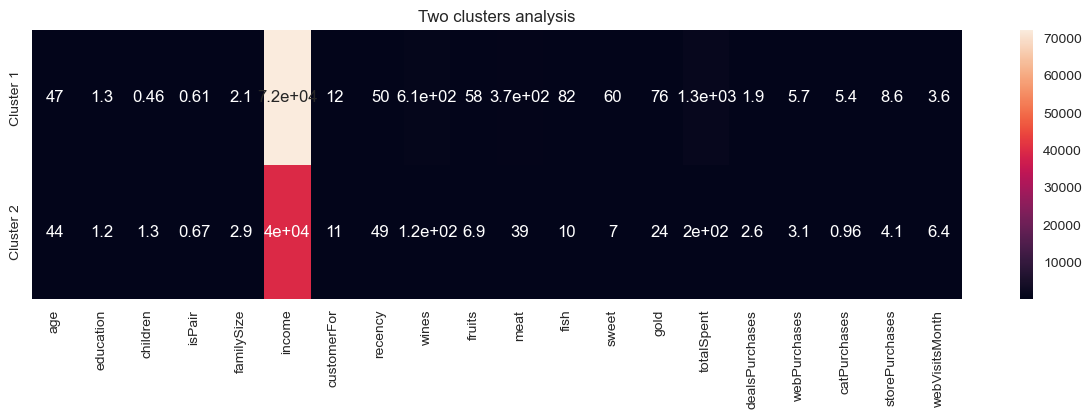

In [12]:
# Analysing 2 customer groups
plt.figure(figsize=(15,3.5))
plt.title('Two clusters analysis')
fig = sns.heatmap(scaler.inverse_transform(kmeans_2groups.cluster_centers_),
            annot=True,
            yticklabels=['Cluster 1','Cluster 2'],
            xticklabels=scaled_customers.columns)

<Axes: title={'center': 'Two clusters analysis'}>

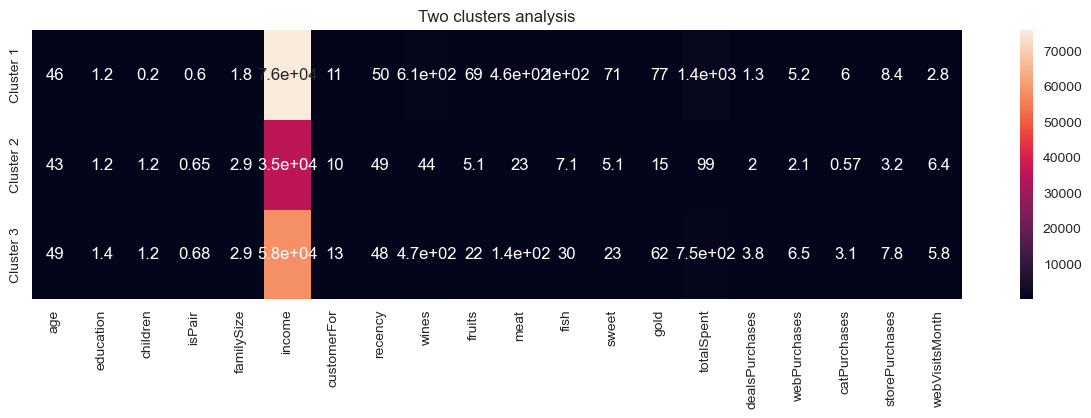

In [13]:
# Analysing 3 customer groups
plt.figure(figsize=(15,3.5))
plt.title('Two clusters analysis')
sns.heatmap(scaler.inverse_transform(kmeans_3groups.cluster_centers_),
            annot=True,
            yticklabels=['Cluster 1','Cluster 2', 'Cluster 3'],
            xticklabels=scaled_customers.columns)
#plt.savefig('../visualization/three_clusters.png')

Analysing each cluster for two and three clusters, the three clusters seems to have better groups. Analysing the 3 cluster algorithm, we have:

**Cluster 1**:
* Highest income value of all clusters;
* Low number of children, closer to zero;
* It is the cluster that most buy all products: wines, fruits, meat, fish, sweet and gold;
* Does not like deals purchases;
* Store, catalog and web purchases are the main channels, respectively.

**Business insights:** This cluster should be the focus of the grocery store because these customers buy a lot and spend a lot of money. They buy almost all kinds of food. The main channel to focus are store and catalog, respectively. They also buy a lot on the web, but do not visit much the web page, so this is secondary focus. These customers have high income, so it is not a problem to show expensive products for them.

**Cluster 2**:
* Smallest income value of all clusters;
* Like the third cluster, usually has one children;
* That is the cluster that less buys products of all clusters;
* It is the cluster that has most web visits but does not buy much on web;

**Business insights:** This cluster should not be the focus at all of the grocery store. These customers spend very little money in products and buy almost nothing. They visit the web page a lot but does not buy any product.

**Cluster 3**:
* Average income value comparing to other clusters;
* Like the second cluster, usually has one children;
* This cluster of customers buys a lot of products, but less than the first cluster;
* Usually this cluster likes to use deals purchases;
* This cluster makes a lot of web visits and also buys a lot on web;
* Also buys a lot in the store, but less than group 1.

**Business insights:** This cluster should be the second focus of the grocery store. These customers buys some products and spend some money in the grocery store. Usually, they visit a lot the web page and buy mainly on the web. These customers have a mean income, so it is good to show them low or middle cost products.

In [15]:
# 3 clusters seems better, so we will save the three_clusters model

# SAVE 3 CLUSTERS MODEL
dump(kmeans_3groups, open('../data/interim/kmeans_3_segments.pickle', "wb"))